# Download competition data

(unnecessary in kaggle)

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [4]:
!kaggle competitions download -cq tabular-playground-series-mar-2022

!unzip -qn train.csv.zip
!rm train.csv.zip

  0% 0.00/4.69M [00:00<?, ?B/s]
100% 4.69M/4.69M [00:00<00:00, 43.4MB/s]
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


# Solution

## Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## Load data

* train.csv - the training set, comprising measurements of traffic congestion across __65 roadways__ from April through September of 1991.
  * row_id - a unique identifier for this instance
  * time - the 20-minute period in which each measurement was taken
  * x - the east-west midpoint coordinate of the roadway
  * y - the north-south midpoint coordinate of the roadway
  * direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
  * congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.
* test.csv - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of __1991-09-30__.
* sample_submission.csv - a sample submission file in the correct format

In [6]:
train = pd.read_csv("train.csv", index_col="row_id", parse_dates=["time"])
test = pd.read_csv("test.csv", index_col="row_id", parse_dates=["time"])
submission = pd.read_csv("sample_submission.csv", index_col="row_id")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848835 entries, 0 to 848834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        848835 non-null  datetime64[ns]
 1   x           848835 non-null  int64         
 2   y           848835 non-null  int64         
 3   direction   848835 non-null  object        
 4   congestion  848835 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 38.9+ MB


In [8]:
train.head(5)

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01,0,0,EB,70
1,1991-04-01,0,0,NB,49
2,1991-04-01,0,0,SB,24
3,1991-04-01,0,1,EB,18
4,1991-04-01,0,1,NB,60


In [9]:
print(train['direction'].unique())
print(test['direction'].unique())

['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [10]:
print(train['x'].unique(), train['y'].unique())
print(test['x'].unique(), test['y'].unique())

[0 1 2] [0 1 2 3]
[0 1 2] [0 1 2 3]


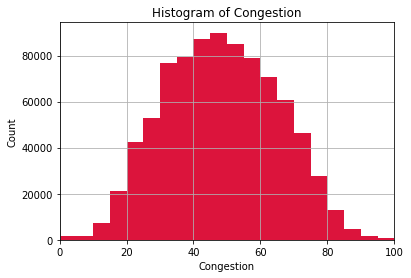

In [11]:
n, bins, patches = plt.hist('congestion', data=train, bins=20, color='crimson')


plt.xlabel('Congestion')
plt.ylabel('Count')
plt.title('Histogram of Congestion')
plt.xlim(0, 100)
plt.grid(True)
plt.show()

## Feature engineering

In [12]:
train['road'] = train[['x','y','direction']].apply(tuple, axis=1)
train.head(5)

,time,x,y,direction,congestion,road
row_id,,,,,,
0,1991-04-01,0,0,EB,70,"(0, 0, EB)"
1,1991-04-01,0,0,NB,49,"(0, 0, NB)"
2,1991-04-01,0,0,SB,24,"(0, 0, SB)"
3,1991-04-01,0,1,EB,18,"(0, 1, EB)"
4,1991-04-01,0,1,NB,60,"(0, 1, NB)"


In [33]:
roads = {i:c for i,c in enumerate(train.road.unique())}
rev_roads = {c:i for i,c in enumerate(train.road.unique())}
directions = {i:c for i,c in enumerate(train.direction.unique())}
rev_directions = {c:i for i,c in enumerate(train.direction.unique())}

In [34]:
train['road_id'] = [rev_roads[r] for r in train.road]
train['direction_id'] = [rev_directions[r] for r in train.direction]
train.tail(10)

,time,x,y,direction,congestion,road,road_id,month,day,hour,minute,days_past,weekday,is_weekend,direction_id
row_id,,,,,,,,,,,,,,,
818535,1991-09-23 23:40:00,2,2,SB,52,"(2, 2, SB)",55,9,23,23,40,175,0,0,2
818536,1991-09-23 23:40:00,2,2,SE,20,"(2, 2, SE)",56,9,23,23,40,175,0,0,7
818537,1991-09-23 23:40:00,2,2,SW,45,"(2, 2, SW)",57,9,23,23,40,175,0,0,5
818538,1991-09-23 23:40:00,2,2,WB,62,"(2, 2, WB)",58,9,23,23,40,175,0,0,3
818539,1991-09-23 23:40:00,2,3,EB,44,"(2, 3, EB)",59,9,23,23,40,175,0,0,0
818540,1991-09-23 23:40:00,2,3,NB,68,"(2, 3, NB)",60,9,23,23,40,175,0,0,1
818541,1991-09-23 23:40:00,2,3,NE,18,"(2, 3, NE)",61,9,23,23,40,175,0,0,4
818542,1991-09-23 23:40:00,2,3,SB,74,"(2, 3, SB)",62,9,23,23,40,175,0,0,2
818543,1991-09-23 23:40:00,2,3,SW,11,"(2, 3, SW)",63,9,23,23,40,175,0,0,5


Every locations are at least an intersection

In [15]:
for group_key, group_value in train.groupby(['x', 'y']):
  print(group_key, group_value['direction'].unique())

(0, 0) ['EB' 'NB' 'SB']
(0, 1) ['EB' 'NB' 'SB' 'WB']
(0, 2) ['EB' 'NB' 'SB' 'WB']
(0, 3) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
(1, 0) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
(1, 1) ['EB' 'NB' 'SB' 'WB']
(1, 2) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
(1, 3) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']
(2, 0) ['EB' 'NB' 'SB' 'WB']
(2, 1) ['EB' 'NB' 'NE' 'NW' 'SB' 'SE' 'SW' 'WB']
(2, 2) ['EB' 'NB' 'NE' 'NW' 'SB' 'SE' 'SW' 'WB']
(2, 3) ['EB' 'NB' 'NE' 'SB' 'SW' 'WB']


In [16]:
def preprocess(data):
  data['month'] = [d.month for d in data['time']]
  data['day'] = [d.day for d in data['time']]
  data['hour'] = [d.hour for d in data['time']]
  data['minute'] = [d.minute for d in data['time']]

  march_first = datetime.date(1991,4,1)
  data['days_past'] = [(d.date()-march_first).days for d in data['time']]
  data['weekday'] = data['days_past']%7
  data['is_weekend'] = np.where((data['weekday']-4)>0, 1, 0)
  return data

In [17]:
for df in (train, test):
  preprocess(df)

## Training

In [21]:
time_feature = ['weekday','is_weekend','hour','minute','days_past', 'day','month']
geo_feature = ['road_id','x','y']
all = time_feature + geo_feature

In [35]:
# !EXPERIMENTAL!
time_feature = ['hour', 'minute', 'day', 'month']
geo_feature = ['road_id', 'x', 'y', 'direction_id']
all = time_feature + geo_feature
train = train[(train['weekday'] == 0) & (train['hour'] >= 12)]

In [36]:
train_X, val_X, train_y, val_y = train_test_split(train[all], 
                                                  train['congestion'], 
                                                  random_state=1)

In [37]:
model = RandomForestRegressor(max_features='auto',
                              verbose=2, 
                              random_state=1)
model.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.8s finished


RandomForestRegressor(random_state=1, verbose=2)

In [38]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 2,
 'warm_start': False}

In [54]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 300, num = 5)]
max_features = ['auto']
max_depth = [90]
max_depth.append(None)
min_samples_split = [5, 7]
min_samples_leaf = [2, 4]
bootstrap = [True]


In [55]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [58]:
rf = RandomForestRegressor(random_state=1)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 5, 
                               cv = 2, 
                               verbose=2, 
                               random_state=1)

In [ ]:
rf_random.fit(train_X, train_y)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=  10.7s


In [50]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [51]:
model = RandomForestRegressor(bootstrap=True,
                              max_depth=90,
                              max_features='auto',
                              min_samples_leaf=2,
                              min_samples_split= 5,
                              n_estimators=200)
model.fit(train_X, train_y)

RandomForestRegressor(max_depth=90, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200)

In [52]:
for k,v in dict(zip(all, model.feature_importances_)).items():
  print(f'{k} : {v:.3f}')

hour : 0.097
minute : 0.025
day : 0.065
month : 0.039
road_id : 0.428
x : 0.043
y : 0.045
direction_id : 0.258


* road_id is the most relevant feature
* weekend or not traffic looks pretty similar
* does it make sense that y is 10 times more important than x is !?!

In [53]:
print(mean_absolute_error(val_y, model.predict(val_X)))
print(mean_absolute_error(val_y, model.predict(val_X).round()))

5.453076254506829
5.447468770545694
